In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

In [9]:
# ------------- SETTINGS --------------------------------------
cut = True
verbose = False
plot_from_date = "2022-05-31 15:40:00" #Starting data of the test (data before is neglected)
plot_till_date = "2022-06-07 19:40:00" #End date of the test (data after is neglected)
zero_date_start = "2022-05-31 15:40:00" # Start timestamp for offset test step (0,0 inclination)
zero_date_end = "2022-05-31 19:40:00" # End timestamp for offset test step
ref_threshold = 1.0 # Maximum difference with reference for datapoint to be considered valid
sb_numbers = [148107, 148098, 148097, 148091, 148088, 148076] # List of SmartBrick serial numbers to be evaluated
x_settings = [-5, -2, 0, 2, 5]
y_settings = [-10, -5, -2, 0, 2, 5, 10]


In [10]:
data_path = os.path.join(os.path.abspath("").removesuffix('CA_analysis.ipynb'), "Data")

# ------------- LOAD THE DATA --------------------------------------
dfs = []

for sb_number in sb_numbers:
    x_path = os.path.join(data_path, str(sb_number)+'_x.csv')
    y_path = os.path.join(data_path, str(sb_number)+'_y.csv')

    names = ['Series', 'Date', 'Value']
    x_df = pd.read_csv(x_path, delimiter=',"', header=1, engine='python', names=names).replace('"','', regex=True)
    x_df['Date'] = pd.to_datetime(x_df["Date"], format = "%Y-%m-%d %H:%M:%S")
    y_df = pd.read_csv(y_path, delimiter=',"', header=1, engine='python', names=names).replace('"','', regex=True)

    x_df['Value'] = pd.to_numeric(x_df['Value'], downcast="float")
    y_df['Value'] = pd.to_numeric(y_df['Value'], downcast="float")

    # Delete before and after
    data = [x_df["Date"], x_df["Value"], y_df["Value"]]
    headers = ['Datetime', 'X value', 'Y value']
    data = pd.concat(data, axis=1, keys=headers)

    data["Datetime"] = pd.to_datetime(data["Datetime"], format = "%Y-%m-%d %H:%M:%S")
    data.sort_index(axis=0, ascending=False)
    data = data.set_index("Datetime", drop=False)
    data["Y value"] = -1*data["Y value"]
    if cut:
        delete_before = pd.Timestamp(plot_from_date) # Year, month, date
        delete_after = pd.Timestamp(plot_till_date)
        data = data.loc[(data.index > delete_before)]
        data = data.loc[(data.index < delete_after)]
        if data.empty:
            raise RuntimeError("Dataframe is empty, check the plotting time interval.")
    dfs.append(data)
if verbose:
    print("Test data dataframes")
    print(dfs)

# ------------- LOAD REFERENCE DATA --------------------------------------
names = ["Datetime", "Y Ref", "X Ref", "Temperature"]
ref_path = os.path.join(os.path.abspath("").removesuffix("CA_analysis.ipynb"), "Data", "jewell_ref_CA_1.txt")
refdf = pd.read_csv(ref_path, delimiter=',', header=1,engine='python', names=names)

refdf["Y Ref"] = -1*refdf["Y Ref"]
refdf["X Ref"] = -1*refdf["X Ref"]

refdf["Datetime"] = pd.to_datetime(refdf["Datetime"], format = "%Y-%m-%d %H:%M:%S")
refdf.sort_index(axis=0, ascending=False)
refdf = refdf.set_index("Datetime", drop=False)
if cut:
    delete_before = pd.Timestamp(plot_from_date) # Year, month, date
    delete_after = pd.Timestamp(plot_till_date)
    refdf = refdf.loc[(refdf.index > delete_before)]
    refdf = refdf.loc[(refdf.index < delete_after)]
if verbose:
    print("Reference df")
    print(refdf)

# ------------- CORRECT OFFSETS --------------------------------------
offset_delete_before = pd.Timestamp(zero_date_start)
offset_delete_after = pd.Timestamp(zero_date_end)

for i in range(len(sb_numbers)):
    zero_df = dfs[i].loc[(dfs[i].index > offset_delete_before)]
    zero_df = zero_df.loc[(zero_df.index < offset_delete_after)]
    y_offset = zero_df["Y value"].mean()
    x_offset = zero_df["X value"].mean()

    # Subtract the offset
    dfs[i]["Y value"] -= y_offset
    dfs[i]["X value"] -= x_offset

# Ref offset
zero_df = refdf.loc[(refdf.index > offset_delete_before)]
zero_df = zero_df.loc[(zero_df.index < offset_delete_after)]
ref_yoffset = zero_df["Y Ref"].mean()
ref_xoffset = zero_df["X Ref"].mean()
refdf["Y Ref"] -= ref_yoffset
refdf["X Ref"] -= ref_xoffset
if verbose:
    print("Test dataframe without offsets")
    print(dfs)
    print("Reference dataframe without offsets")
    print(refdf)

# ------------- MATCH REF AND TEST DATA --------------------------------------
for i in range(len(sb_numbers)):
# For each row of the self.dfs[i], look for the closest matching datetime in self.refdf
# Finding closest matching datetime in self.refdf: For each row, calculate time difference (absolute). Select smallest time difference
    yref_column = []
    xref_column = []
    for index,row in dfs[i].iterrows():
        current_datetime = row["Datetime"] # datatype timestamp
        refdf["Time Difference"] = abs(refdf["Datetime"] - current_datetime)/np.timedelta64(1, 's')

        min_index = refdf["Time Difference"].idxmin()
        yref_column.append(refdf.loc[min_index,"Y Ref"])
        xref_column.append(refdf.loc[min_index,"X Ref"])
    dfs[i]["Y Ref"] = yref_column
    dfs[i]["X Ref"] = xref_column

    # Delete rows if delta angle is larger or smaller than 1.0
    dfs[i]["Delta Y ref"] = dfs[i]["Y Ref"]-dfs[i]["Y value"]
    dfs[i] = dfs[i][dfs[i]["Delta Y ref"]< ref_threshold]
    dfs[i] = dfs[i][dfs[i]["Delta Y ref"]>-1*ref_threshold]

    dfs[i]["Delta X ref"] = dfs[i]["X Ref"]-dfs[i]["X value"]
    dfs[i] = dfs[i][dfs[i]["Delta X ref"]< ref_threshold]
    dfs[i] = dfs[i][dfs[i]["Delta X ref"]>-1*ref_threshold]

    dfs[i] = dfs[i].drop(columns=['Delta Y ref'])
    dfs[i] = dfs[i].drop(columns=['Delta X ref'])
if verbose:
    print("Test data dataframes with reference")
    print(dfs)

# ------------- GROUP DATA --------------------------------------
bins_x = [-5.0, -2.774, -0.592, 1.59, 3.772, 6.0]
bins_y = [-10.0, -6.5, -3.4, -0.4, 1.5, 5.7, 8.7, 12.0]

for i in range(len(sb_numbers)):
    dfs[i]["X setting"] = pd.cut(dfs[i]["X Ref"], bins = bins_x, labels=x_settings)
    dfs[i]["Y setting"] = pd.cut(dfs[i]["Y Ref"], bins = bins_y, labels=y_settings)
    
if verbose:
    print("Dataframes with set angles for grouping")
    print(dfs)

In [11]:
# Small cell for checking the data imports, not necessary to run
count=0
index = 5
for group in y_settings:
    print(len(dfs[index].groupby("Y setting").get_group(group)))
    count+=len(dfs[index].groupby("Y setting").get_group(group))
print(count == len(dfs[index]))

286
287
287
336
287
286
286
True


Trendline of Xref vs Y-Yref - 148107
slope: 0.018753, intercept: -0.068942
R-squared: 0.316883




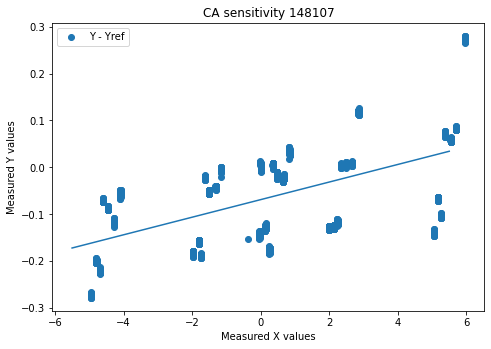

Trendline of Xref vs Y-Yref - 148098
slope: 0.033376, intercept: 0.050978
R-squared: 0.834853




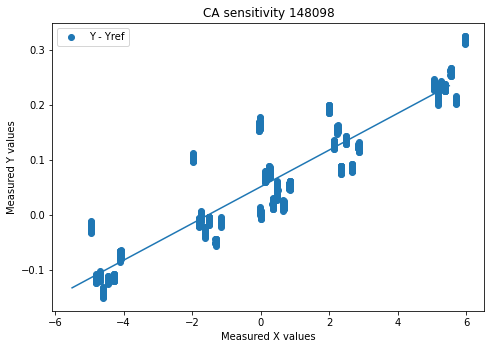

Trendline of Xref vs Y-Yref - 148097
slope: 0.015043, intercept: 0.225598
R-squared: 0.328378




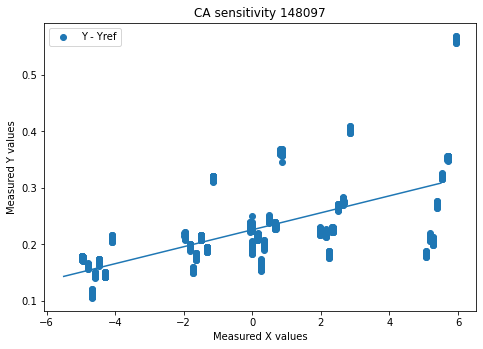

Trendline of Xref vs Y-Yref - 148091
slope: 0.054262, intercept: 0.034726
R-squared: 0.924321




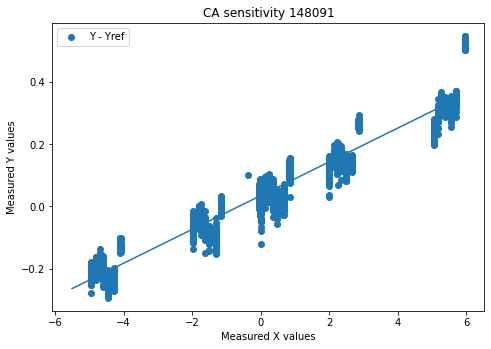

Trendline of Xref vs Y-Yref - 148088
slope: -0.005987, intercept: -0.005317
R-squared: 0.019963




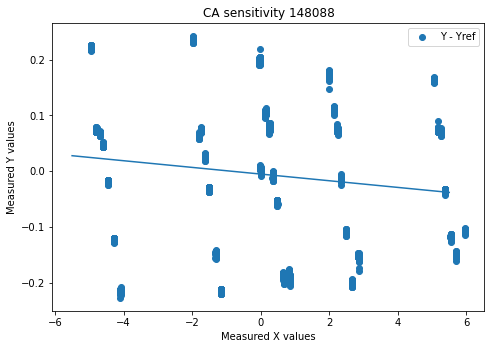

Trendline of Xref vs Y-Yref - 148076
slope: 0.024245, intercept: -0.034936
R-squared: 0.750663




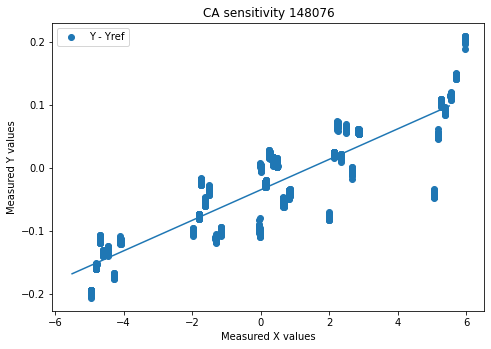

In [18]:
# ------------------- TRENDLINE STATISTICS -----------------------------
for i in range(len(sb_numbers)):
    xlist = dfs[i]['X Ref'].tolist()
    ylist = (dfs[i]['Y value']-dfs[i]["Y Ref"]).tolist()

    xarray = np.array(xlist)
    yarray = np.array(ylist)

    slope, intercept, r_value, p_value, std_err = linregress(xarray, yarray)
    print("Trendline of Xref vs Y-Yref - "+str(sb_numbers[i]))
    print("slope: %f, intercept: %f" % (slope, intercept))
    print("R-squared: %f" % r_value**2)
    print("\n")


    x_data = xlist
    y_data = ylist
    
    fig = plt.figure()
    ax = fig.add_axes([1,1,1,1])
    ax.scatter(x_data, y_data, label="Y - Yref")

    x = np.linspace(-5.5,5.5,1000)
    y = slope * x + intercept
    ax.plot(x,y)
    ax.legend()
    ax.set_title("CA sensitivity " + str(sb_numbers[i]))
    ax.set_xlabel('Measured X values')
    ax.set_ylabel('Measured Y values')
    plt.show()
    fig.savefig("Trendline "+str(sb_numbers[i]), bbox_inches='tight')



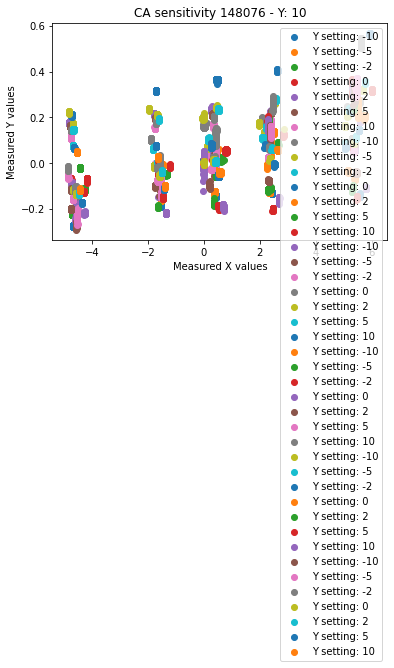

In [104]:
# ------------- Plot --------------------------------------
for i in range(len(sb_numbers)):
    for y_setting in y_settings:
        x_data = dfs[i].groupby("Y setting").get_group(y_setting)["X value"]
        y_data = dfs[i].groupby("Y setting").get_group(y_setting)["Y value"]-dfs[i].groupby("Y setting").get_group(y_setting)["Y Ref"]
        
        plt.scatter(x_data, y_data, label="Y setting: "+str(y_setting))
        plt.legend()
        plt.title("CA sensitivity " + str(sb_numbers[i])+ " - Y: "+str(y_setting))
        plt.xlabel('Measured X values')
        plt.ylabel('Measured Y values')


In [129]:
# ------------------------------ HYSTERESE -----------------------------------
for i in range(len(sb_numbers)):
    zero_xs = []
    zero_y = dfs[i].groupby("Y setting").get_group(0)
    zero_xy = zero_y.groupby("X setting").get_group(0)
    zero_xy["Group"] = pd.cut(zero_xy["Datetime"], bins=[pd.to_datetime("2022-05-31 15:30:00"),
    pd.to_datetime("2022-05-31 20:30:00"),
    pd.to_datetime("2022-06-03 23:50:00"),
    pd.to_datetime("2022-06-04 20:00:00")], labels=[1,2,3])


    # Calculate average of x, y for test and ref for each group
    xv_means = []
    xr_means = []
    yv_means = []
    yr_means = []
    for group in [1,2,3]:
        xv_means.append(zero_xy.groupby("Group").get_group(group)["X value"].mean())
        xr_means.append(zero_xy.groupby("Group").get_group(group)["X Ref"].mean())
        yv_means.append(zero_xy.groupby("Group").get_group(group)["Y value"].mean())
        yr_means.append(zero_xy.groupby("Group").get_group(group)["Y Ref"].mean())

# Results
    print("Hystereses results for SmartBrick "+str(sb_numbers[i]))
    print("Experimental setup hystereses (X): ", xr_means[0] - xr_means[1])
    print("Experimental setup hystereses (Y): ", yr_means[0] - yr_means[2])
    print("Hystereses X: ", xv_means[0]-xv_means[1]-(xr_means[0] - xr_means[1]))
    print("Hystereses Y: ", yv_means[0]-yv_means[2]-(yr_means[0] - yr_means[2]))
    print("\n")


Hystereses results for SmartBrick 148107
Experimental setup hystereses (X):  -0.34824166666666667
Experimental setup hystereses (Y):  -0.2261994680851064
Hystereses X:  0.005936185232798263
Hystereses Y:  -0.003853897145453894


Hystereses results for SmartBrick 148098
Experimental setup hystereses (X):  -0.34824166666666667
Experimental setup hystereses (Y):  -0.22619583333333335
Hystereses X:  0.0003412760416666716
Hystereses Y:  -0.018071973077456144


Hystereses results for SmartBrick 148097
Experimental setup hystereses (X):  -0.34834804964539007
Experimental setup hystereses (Y):  -0.22629361702127662
Hystereses X:  -0.031877161736522164
Hystereses Y:  -0.00862679528074059


Hystereses results for SmartBrick 148091
Experimental setup hystereses (X):  -0.34824166666666667
Experimental setup hystereses (Y):  -0.2261994680851064
Hystereses X:  0.009878019205729172
Hystereses Y:  -0.0327210822612681


Hystereses results for SmartBrick 148088
Experimental setup hystereses (X):  -0.348

C:\Users\MartijnBrummelhuis\AppData\Local\Temp\ipykernel_15928\3540594754.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zero_xy["Group"] = pd.cut(zero_xy["Datetime"], bins=[pd.to_datetime("2022-05-31 15:30:00"),
C:\Users\MartijnBrummelhuis\AppData\Local\Temp\ipykernel_15928\3540594754.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zero_xy["Group"] = pd.cut(zero_xy["Datetime"], bins=[pd.to_datetime("2022-05-31 15:30:00"),
C:\Users\MartijnBrummelhuis\AppData\Local\Temp\ipykernel_15928\3540594754.py

[x] Load test and reference data 
[x] Delete before and after test start and end respectively
[x] Match reference data with test data based on timestamps
[x] Correct for offsets
[x] Group data based on x and y angles
[x] Plot x vs y and calculate y/x displacement
[ ] Get into hysteresis